# Smart Grid Stability

https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import xgboost as xgb
print(xgb.__version__)

1.1.0


In [3]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\smart grid'

In [4]:
df = pd.read_csv(dirpath+'/Smart Grid Stability.csv')
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376524,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable


In [5]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


In [6]:
# split data into input and output columns
data = df.values
X = data[:, :-2]
X

array([[2.959060025, 3.0798852039999995, 8.381025392, ..., 0.859578106,
        0.8874449209999999, 0.958033988],
       [9.304097235, 4.902524112, 3.047540728, ..., 0.862414076,
        0.5621390510000001, 0.781759911],
       [8.971706909, 8.848428421, 3.046478749, ..., 0.766688657,
        0.839444015, 0.109853245],
       ...,
       [2.364034189, 2.8420302489999996, 8.776390959, ..., 0.986505321,
        0.149286458, 0.14598403199999999],
       [9.631510693, 3.9943975989999996, 2.7570709339999997, ...,
        0.587557552, 0.889118346, 0.818391326],
       [6.530526615, 6.781789899, 4.349695225, ..., 0.505441048,
        0.37876093, 0.942630833]], dtype=object)

In [7]:
y = data[:,-2]
y

array([0.05534748900000001, -0.005957464, 0.003470879, ..., -0.031809888,
       0.037788809, 0.045263307999999995], dtype=object)

In [8]:
# create an xgboost regression model
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [9]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [10]:
# display scores - force scores to be positive to get mean error
print('Scores: ', scores)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Scores:  [-0.00573191 -0.00576854 -0.00576981 -0.00589289 -0.00612969 -0.00589368
 -0.00596221 -0.00581089 -0.00559945 -0.00574131 -0.00565496 -0.00585521
 -0.00604773 -0.00600927 -0.00570725 -0.0055531  -0.00582132 -0.00549545
 -0.00597873 -0.00605379 -0.00596848 -0.00570802 -0.00569074 -0.00585619
 -0.00575616 -0.00625886 -0.00580037 -0.00592098 -0.00595714 -0.00575154]
Mean MAE: 0.006 (0.000)


In [11]:
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
# make a prediction
row = [8.971707, 8.848428, 3.046479, 1.214518, 3.405158, -1.207456, -1.277210, -0.920492, 0.163041, 0.766689, 0.839444, 0.109853]
new_data = np.asarray([row])
yhat = model.predict(new_data)
yhat

array([0.00390777], dtype=float32)

In [13]:
# make another prediction
row = [2.364034, 2.842030, 8.776391, 1.008906, 4.299976, -1.380719, -0.943884, -1.975373, 0.487838, 0.986505, 0.149286, 0.14598]
new_data = np.asarray([row])
yhat = model.predict(new_data)
yhat

array([-0.03156763], dtype=float32)

In [14]:
row = [
    np.random.randint(287,762)/100,
    np.random.randint(287,762)/100,
    np.random.randint(287,762)/100,
    np.random.randint(287,762)/100,
    np.random.randint(321,428)/100,
    -np.random.randint(87,162)/100,
    -np.random.randint(87,162)/100,
    -np.random.randint(87,162)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100
]

print(row)

new_data = np.asarray([row])
yhat = model.predict(new_data)
yhat

[4.75, 3.19, 5.64, 4.46, 4.18, -1.21, -1.57, -0.93, 0.39, 0.38, 0.47, 0.53]


array([0.02028435], dtype=float32)

In [15]:
row = [
    np.random.randint(50,999)/100,
    np.random.randint(50,999)/100,
    np.random.randint(50,999)/100,
    np.random.randint(50,999)/100,
    np.random.randint(321,428)/100,
    -np.random.randint(87,162)/100,
    -np.random.randint(87,162)/100,
    -np.random.randint(87,162)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100,
    np.random.randint(28,76)/100
]

print(row)

new_data = np.asarray([row])
yhat = model.predict(new_data)
yhat

[7.18, 5.39, 6.46, 6.47, 4.22, -1.18, -1.51, -1.54, 0.71, 0.54, 0.53, 0.69]


array([0.07823968], dtype=float32)

In [16]:
df2 = df.copy()
df2 = df2.sort_values(['stab'])
df2

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
2433,1.720416,0.961461,7.976768,1.363837,3.299132,-1.074233,-1.099751,-1.125147,0.902871,0.632256,0.544420,0.266887,-0.080760,stable
7016,2.926590,0.953738,1.291587,8.092160,4.249190,-1.970382,-1.749026,-0.529781,0.773768,0.240372,0.600525,0.353740,-0.074923,stable
2120,1.726834,1.488897,0.957949,7.979088,5.195525,-1.472739,-1.824813,-1.897972,0.762860,0.559017,0.567828,0.111914,-0.070529,stable
7923,1.888825,1.435741,5.548242,8.075927,3.633392,-0.626204,-1.194054,-1.813134,0.606828,0.605213,0.214688,0.301742,-0.070484,stable
2051,7.309765,0.678899,3.121928,0.974155,4.432176,-1.635800,-1.454535,-1.341841,0.356806,0.191537,0.917210,0.858202,-0.069501,stable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,3.364047,4.360096,5.437092,3.113855,5.047793,-1.877902,-1.201232,-1.968659,0.985063,0.817243,0.690916,0.990943,0.107060,unstable
7353,7.508768,4.733572,7.187613,8.315267,4.297900,-0.561722,-1.913186,-1.822992,0.661316,0.982624,0.982019,0.973278,0.107272,unstable
7614,4.781792,5.610616,4.515092,5.183316,2.242506,-0.780331,-0.575404,-0.886771,0.788743,0.998578,0.440689,0.981118,0.107380,unstable
4641,6.234559,6.737989,6.091729,6.554616,2.131215,-0.518313,-0.870694,-0.742208,0.933281,0.855880,0.930158,0.583177,0.108971,unstable


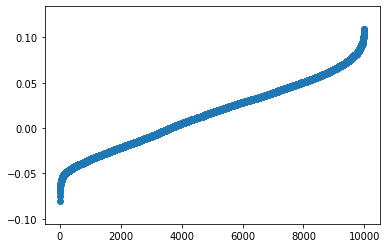

In [22]:
plt.scatter(range(10000), df2['stab'])